In [1]:
# imports
import torch

import learning.ppo.utils
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
# preparation
episodes = 100
steps = 25
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

# Set seed for all randomness sources
seed = 0

# init environments
envs = {
    "one-agent": {"agent_amount": 1},
    "two-agents": {"agent_amount": 2},
    "two-agents-mixed": {"agent_amount": 2, "setting": "mixed-motive"},
    "two-agents-percentage": {
        "agent_amount": 2, 
        "setting": "percentage-reward"
    },
    "three-agents": {"agent_amount": 3}
}

# init data logging 
log_data = {}

Device: cpu



In [7]:
def load_environment(env_setting):
    env_id = "Empty-Grid-v0"
    print(env_setting)
    if "setting" in env_setting:
        env = learning.ppo.utils.make_env(
            env_id, env_setting["agent_amount"], seed=seed, setting=env_setting["setting"])
    else:
        env = learning.ppo.utils.make_env(
            env_id, env_setting["agent_amount"], seed=seed)
    return env

def load_agents(agent_amount, env, model): 
    model_dir = learning.ppo.utils.get_short_model_dir(model)
    agents = []
    if hasattr(env.action_space, 'n'):
        action_space = env.action_space.n
    else: # multi dim (market) action 
        action_space = env.action_space.nvec.prod()

    for agent in range(agent_amount):
        agents.append(learning.ppo.utils.Agent(agent, env.observation_space, 
            action_space, model_dir, device=device))
    return agents

In [8]:
for key, env_settings in envs.items():
    #load environments and their agents
    env = load_environment(env_settings)
    agents = load_agents(env_settings["agent_amount"], env, key)


    # prepare logging
    for agent in range(len(agents)):
        log_data[key+"-reward-"+str(agent)] = []
    log_data[key+"-reset-fields"] = []
    log_data[key+"-grid-solved"] = []
    log_data[key+"-coloration-percentage"] = []

    # gather the plotting data
    for episode in range(episodes):
        reset_fields = 0
        obs = env.reset()
        for step in range(0,steps):
            joint_actions = []
            for agent_index, agent in enumerate(agents):
                action = agent.get_action(obs, agent_index)
                joint_actions.append(action)

            obs, reward, done, info = env.step(joint_actions)
            reset_fields += info["reset_fields"]
            
            if done or step == steps-1: 
                # save reward here since we work with sparse rewards
                for agent, agent_reward in enumerate(reward):
                    log_data[key+"-reward-"+str(agent)].append(agent_reward)
                log_data[key+"-reset-fields"].append(reset_fields)
                log_data[key+"-coloration-percentage"].append(info["coloration_percentage"])
                if 1 in reward:
                    log_data[key+"-grid-solved"].append(1)
                else:
                    log_data[key+"-grid-solved"].append(0)
                    
                break

{'agent_amount': 1}
---------> max steps:  25
---- GRID FULLY COLORED! ---- steps 13
---- GRID FULLY COLORED! ---- steps 9
---- GRID FULLY COLORED! ---- steps 21
---- GRID FULLY COLORED! ---- steps 14
---- GRID FULLY COLORED! ---- steps 17
---- GRID FULLY COLORED! ---- steps 13


C:\Users\Zarah\.virtualenvs\Coloring_with_CAP-xNNGJax5\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


---- GRID FULLY COLORED! ---- steps 21
---- GRID FULLY COLORED! ---- steps 14
---- GRID FULLY COLORED! ---- steps 11
---- GRID FULLY COLORED! ---- steps 10
---- GRID FULLY COLORED! ---- steps 19
---- GRID FULLY COLORED! ---- steps 20
---- GRID FULLY COLORED! ---- steps 16
---- GRID FULLY COLORED! ---- steps 18
---- GRID FULLY COLORED! ---- steps 10
---- GRID FULLY COLORED! ---- steps 16
---- GRID FULLY COLORED! ---- steps 8
---- GRID FULLY COLORED! ---- steps 9
---- GRID FULLY COLORED! ---- steps 12
---- GRID FULLY COLORED! ---- steps 13
---- GRID FULLY COLORED! ---- steps 14
---- GRID FULLY COLORED! ---- steps 25
---- GRID FULLY COLORED! ---- steps 15
---- GRID FULLY COLORED! ---- steps 16
---- GRID FULLY COLORED! ---- steps 11
---- GRID FULLY COLORED! ---- steps 16
---- GRID FULLY COLORED! ---- steps 12
---- GRID FULLY COLORED! ---- steps 12
---- GRID FULLY COLORED! ---- steps 9
---- GRID FULLY COLORED! ---- steps 15
---- GRID FULLY COLORED! ---- steps 13
---- GRID FULLY COLORED! ---

In [9]:
line_styles = ["-", "--", "-.", ":", ".", ",", "o", "v", "^", "<", ">"]
colors = ["b", "g", "r", "c", "m", "y"]

def plot_data(log_key, title):
    plt.figure(figsize=(20,10))
    counter = 0
    for key, env_settings in envs.items():
        color = colors[counter] if counter < len(colors) else colors[len(colors)%counter]   
        if log_key == "reward":
            if "setting" in env_settings and "mixed" in env_settings["setting"]:
                # "mixed" distinguished between agents, so plot every agent
                for agent in range(env_settings["agent_amount"]):
                    line_style = line_styles[agent] if agent < len(line_styles) else line_styles[len(line_styles)%agent]        
                    plt.plot(log_data[key+"-"+log_key+"-"+str(agent)], color+line_style, label = key+str(agent))
            else:
                # else just plot one agent since values between agents are equal
                line = color + line_styles[0]
                plt.plot(log_data[key+"-"+log_key+"-0"], line, label = key)
        else:
            plt.plot(log_data[key+"-"+log_key], color, label = key)
            
        counter += 1

    plt.ylabel(log_key)
    plt.xlabel('episode')
    plt.grid(True)
    plt.title(title)
    plt.legend()
    plt.show()

def plot_barchart(labels, values, ylabel, title):
    plt.figure(figsize=(20,10))
    y_pos = np.arange(len(labels))
    bars = plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, labels)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show

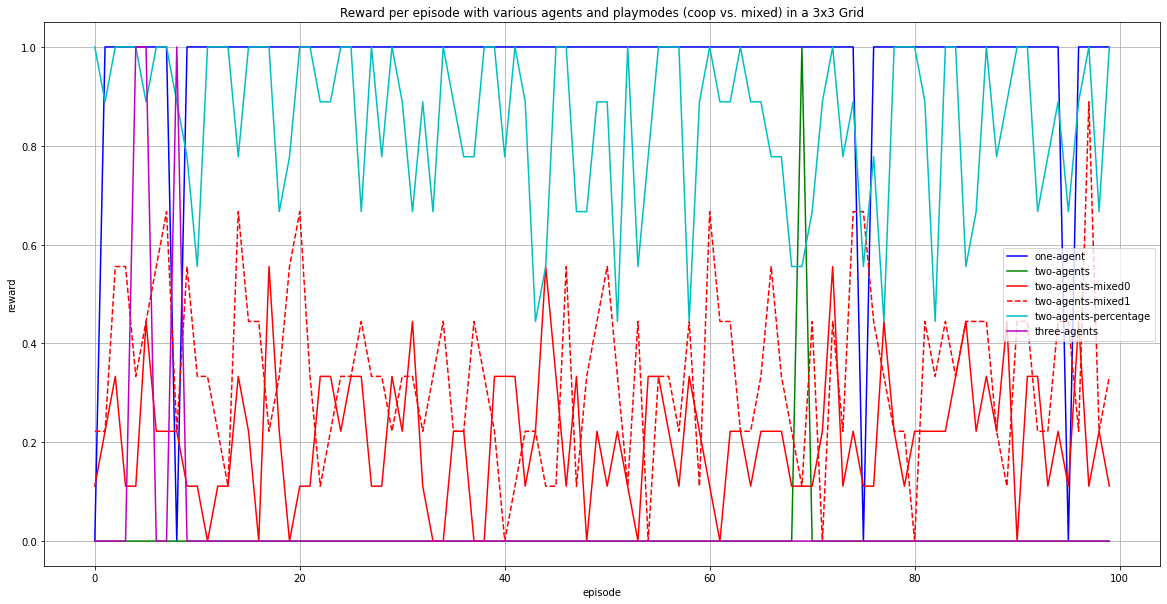

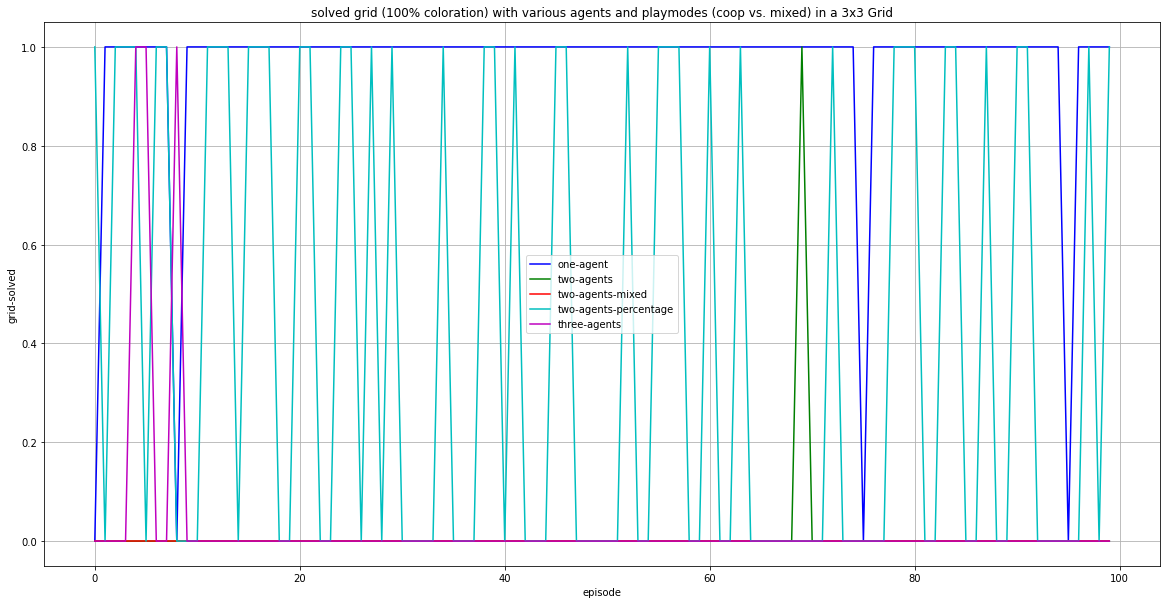

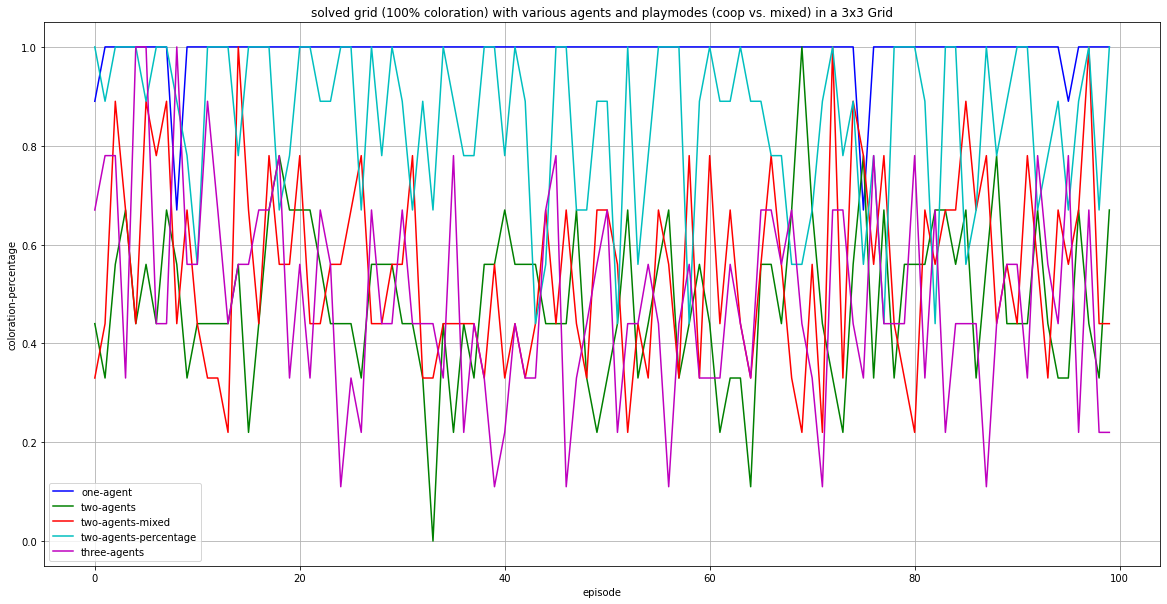

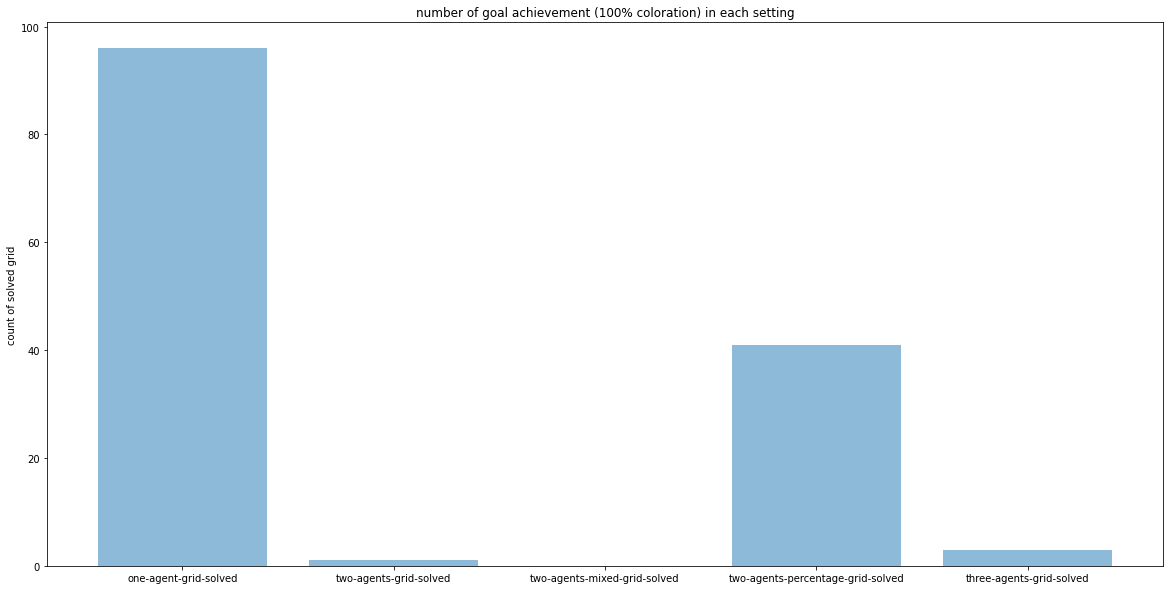

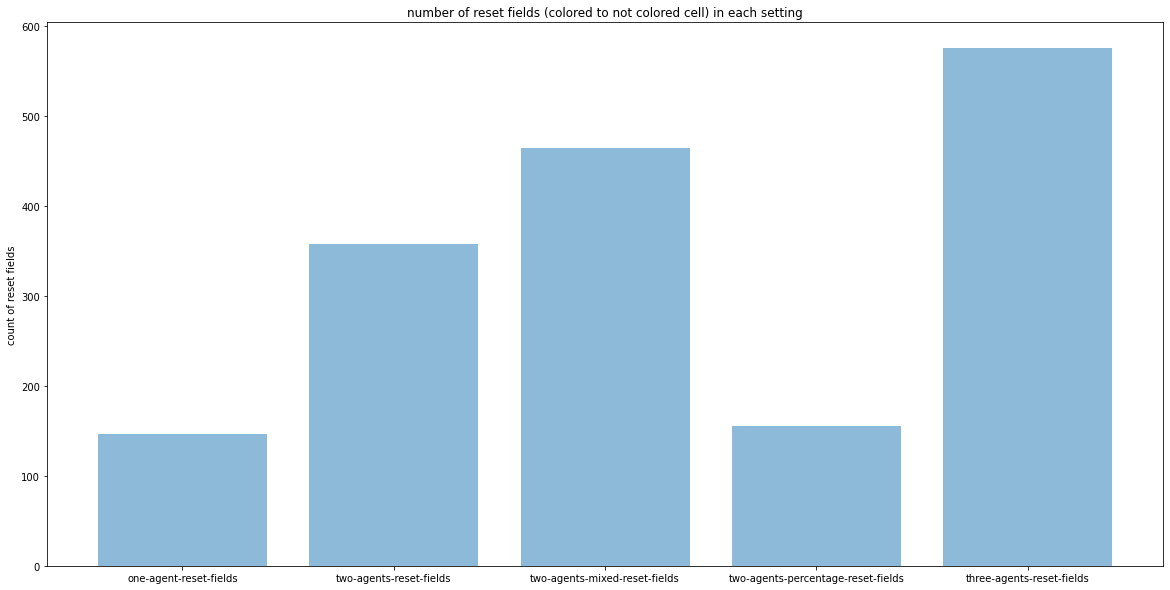

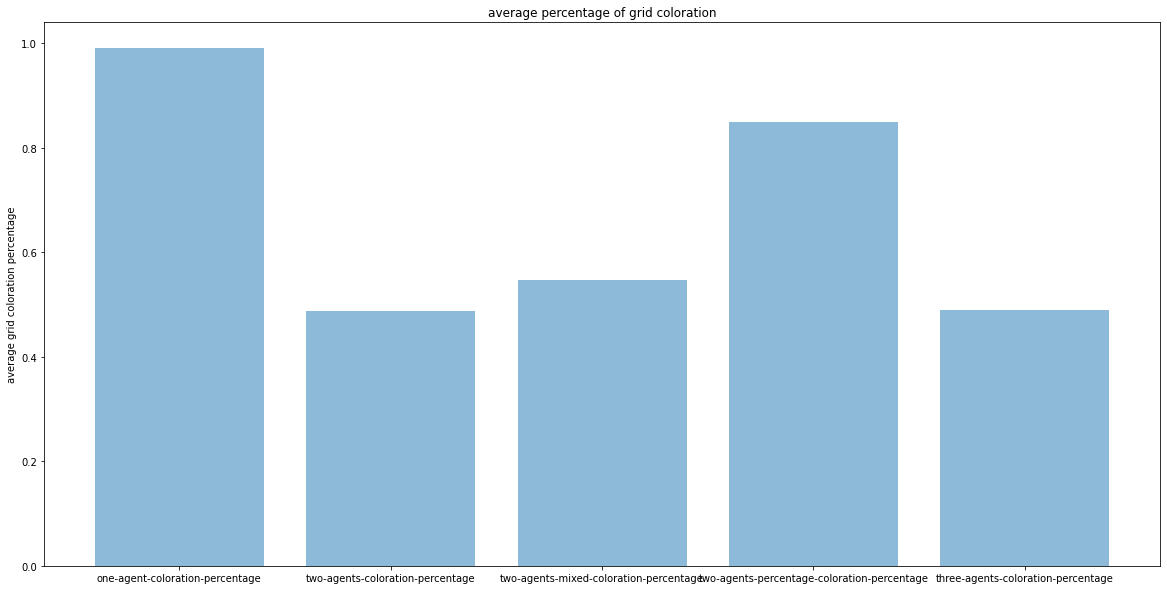

In [10]:
# plot the data
plot_data("reward", "Reward per episode with various agents and playmodes (coop vs. mixed) in a 3x3 Grid")
plot_data("grid-solved", "solved grid (100% coloration) with various agents and playmodes (coop vs. mixed) in a 3x3 Grid")
plot_data("coloration-percentage", "solved grid (100% coloration) with various agents and playmodes (coop vs. mixed) in a 3x3 Grid")
# plot_data("reset_fields", "Count of reset grid cells (colored to not colored) per episode with variing agent amount and playmode (coop vs. mixed) in a 3x3 Grid")

amount_solved_grid_per_setting = {}
amount_reset_fields_per_setting = {}
avg_grid_coloration_per_setting = {}
for setting, value in log_data.items():
    if "grid-solved" in setting:
        amount_solved_grid_per_setting[setting] = sum(value)
    if "reset-fields" in setting:
        amount_reset_fields_per_setting[setting] = sum(value)
    if "coloration-percentage" in setting:
        avg_grid_coloration_per_setting[setting] = sum(value) / len(value)

plot_barchart(amount_solved_grid_per_setting.keys(), amount_solved_grid_per_setting.values(), "count of solved grid", 
    "number of goal achievement (100% coloration) in each setting")

plot_barchart(amount_reset_fields_per_setting.keys(), amount_reset_fields_per_setting.values(), "count of reset fields", 
    "number of reset fields (colored to not colored cell) in each setting")

plot_barchart(avg_grid_coloration_per_setting.keys(), avg_grid_coloration_per_setting.values(), "average grid coloration percentage", 
    "average percentage of grid coloration")


In [11]:
# create dataframe
df = pd.DataFrame(log_data)
add_mixed_cols = False

all_reward_cols = []
reward_cols = []
reset_fields_cols = []
coloration_percentage_cols = []
grid_solved_cols = []
for col in df.columns:
    if "reward" in col:
        all_reward_cols.append(col)
        if "mixed" in col:
            add_mixed_cols = True
            reward_cols.append(col)
        elif "reward-0" in col:
            # in most cases rewards are the same for all agents so only safe one
            reward_cols.append(col)
    if "grid-solved" in col:
        grid_solved_cols.append(col)
    if "reset-field" in col:
        reset_fields_cols.append(col)
    if "coloration-percentage" in col:
        coloration_percentage_cols.append(col)

if add_mixed_cols:
    df_mixed = df.filter(regex='mixed-reward')
    df.insert(0, "mixed_total", df_mixed.sum(axis=1))
    reward_cols.append("mixed_total")

df_reward = df[reward_cols].transpose().stack().reset_index()
df_reward.rename(columns={0:'reward', "level_0": "setting", "level_1": "episode"}, inplace=True)

df_reset_fields = df[reset_fields_cols].transpose().stack().reset_index()
df_reset_fields.rename(columns={0:'reset_fields', "level_0": "setting", "level_1": "episode"}, inplace=True)

df_grid_solved = df[grid_solved_cols].transpose().stack().reset_index()
df_grid_solved.rename(columns={0:'grid_solved', "level_0": "setting", "level_1": "episode"}, inplace=True)

df_coloration_percentage = df[coloration_percentage_cols].transpose().stack().reset_index()
df_coloration_percentage.rename(columns={0:'pecentage', "level_0": "setting", "level_1": "episode"}, inplace=True)

df_combined_reset_and_solved = pd.merge(df_grid_solved, df_reset_fields["reset_fields"], left_index=True, right_index=True, how='outer')
# df_grid_solved.merge(df_reset_fields["reset_fields"], axis=1) #df.transpose().stack().reset_index()
print(df_combined_reset_and_solved)

                      setting  episode  grid_solved  reset_fields
0       one-agent-grid-solved        0            0             4
1       one-agent-grid-solved        1            1             1
2       one-agent-grid-solved        2            1             0
3       one-agent-grid-solved        3            1             2
4       one-agent-grid-solved        4            1             2
..                        ...      ...          ...           ...
495  three-agents-grid-solved       95            0             4
496  three-agents-grid-solved       96            0             8
497  three-agents-grid-solved       97            0             6
498  three-agents-grid-solved       98            0             6
499  three-agents-grid-solved       99            0             6

[500 rows x 4 columns]


Index(['setting', 'episode', 'reward'], dtype='object')


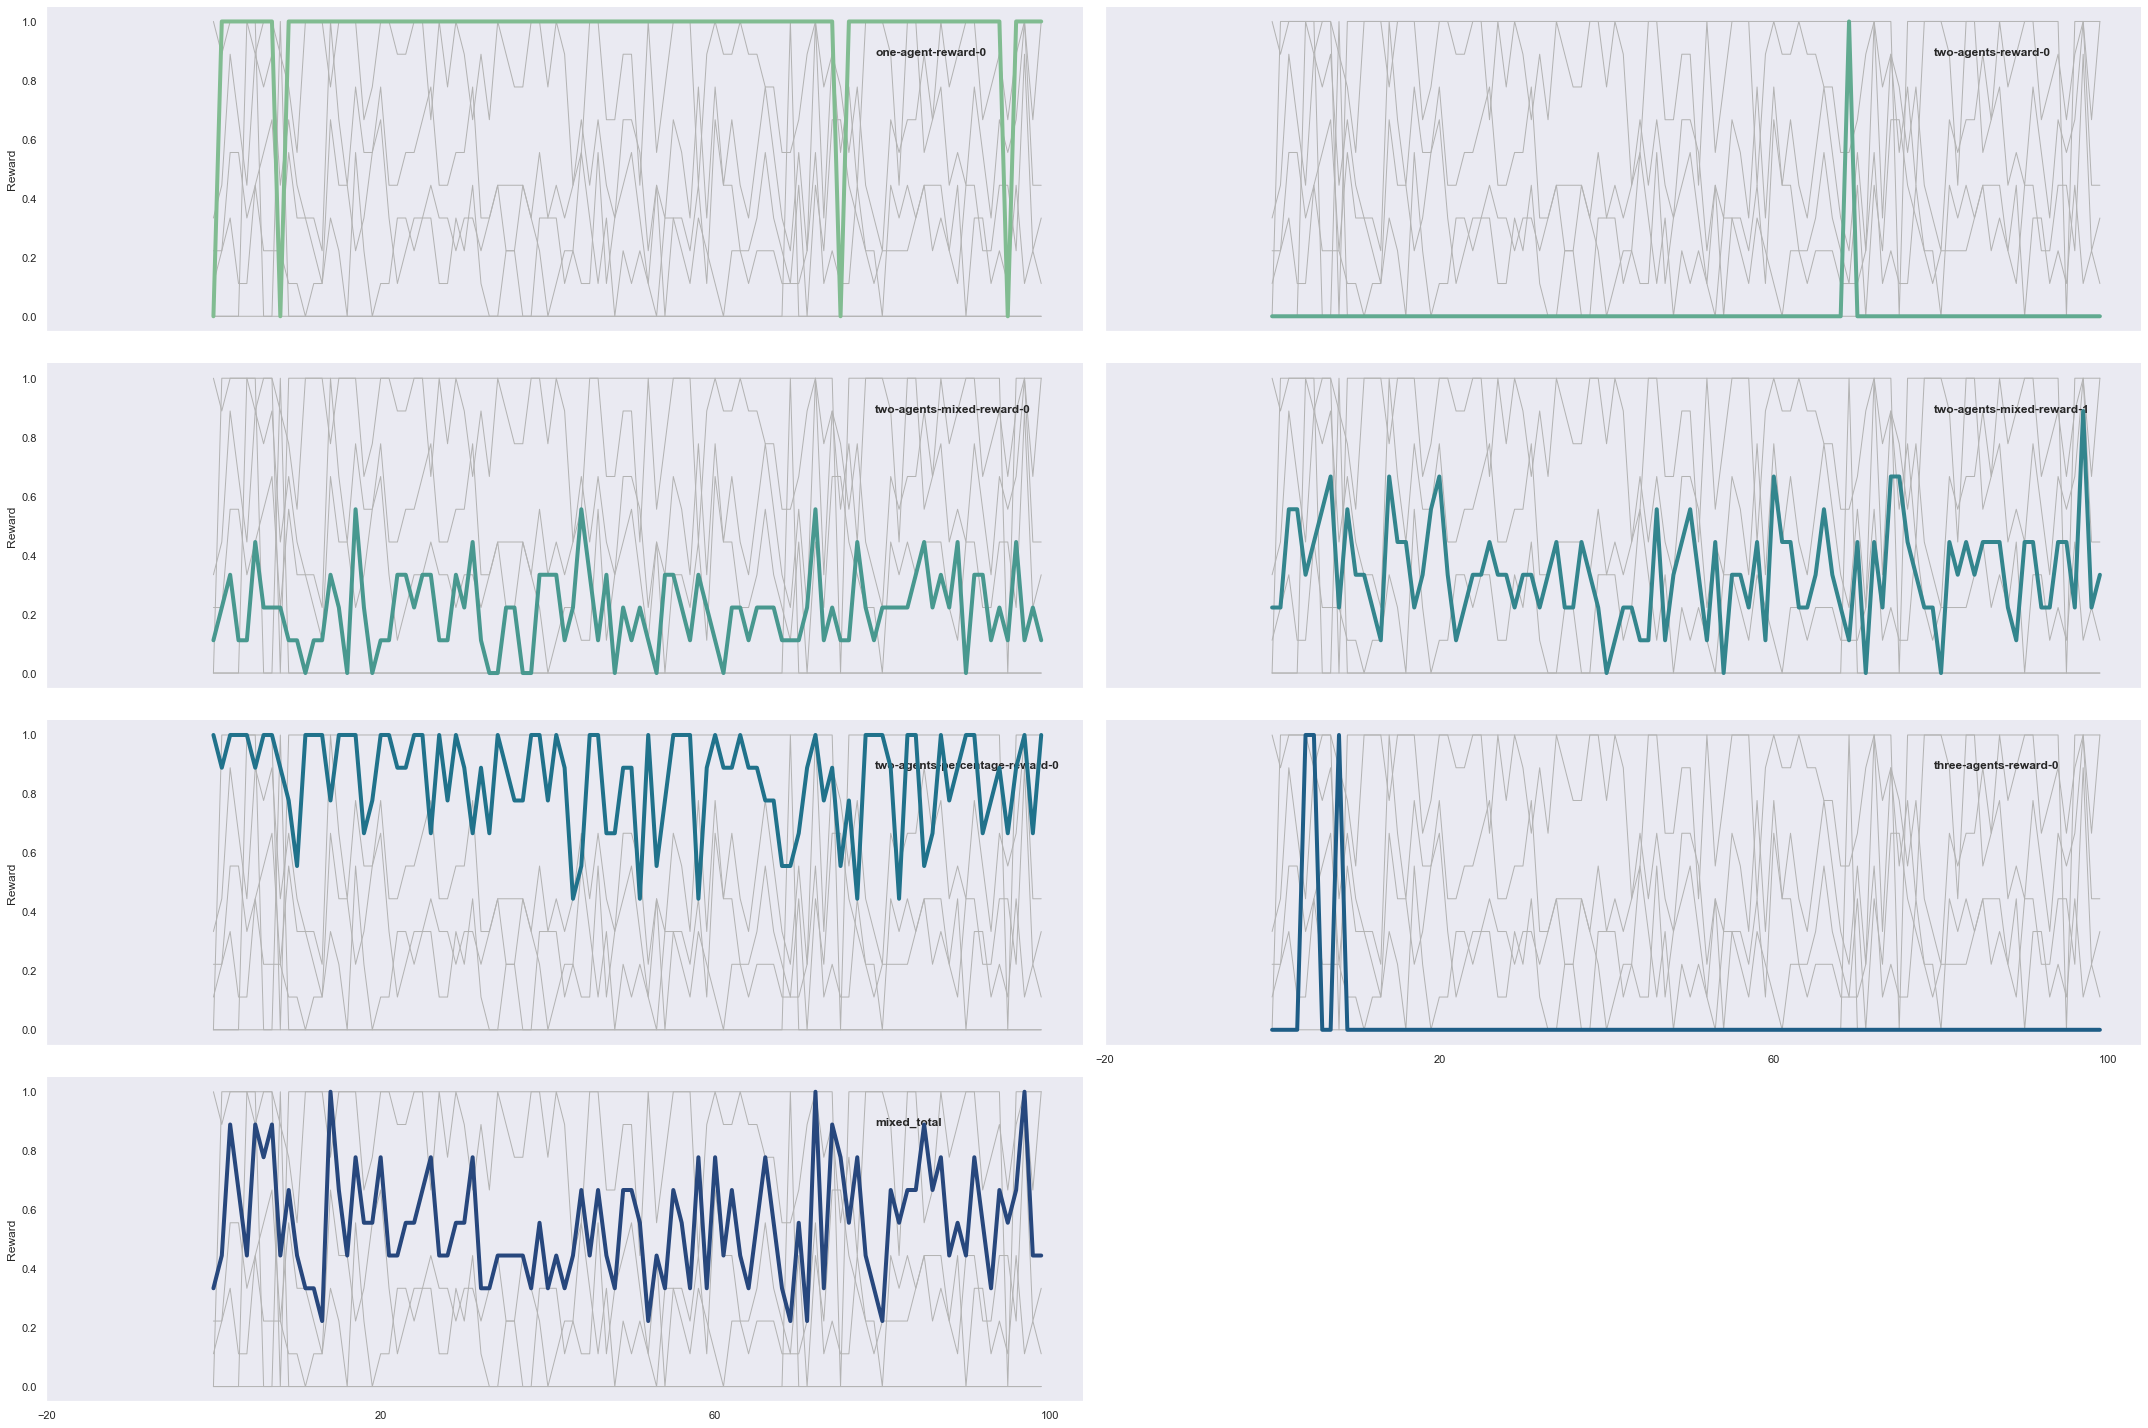

In [12]:
sns.set_theme(style="dark")
print(df_reward.columns)
# Plot each year's time series in its own facet
g = sns.relplot(
    data=df_reward,
    x="episode", y="reward", col="setting", hue="setting",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=2, height=5, aspect=3, legend=False,
)

# Iterate over each subplot to customize further
for setting, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, setting, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=df_reward, x="episode", y="reward", units="setting",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "Reward")
g.tight_layout()

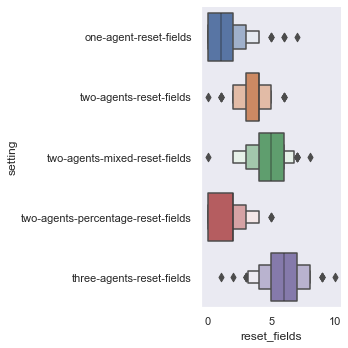

In [13]:
sns.catplot(x="reset_fields", y="setting", kind="boxen", data=df_reset_fields)

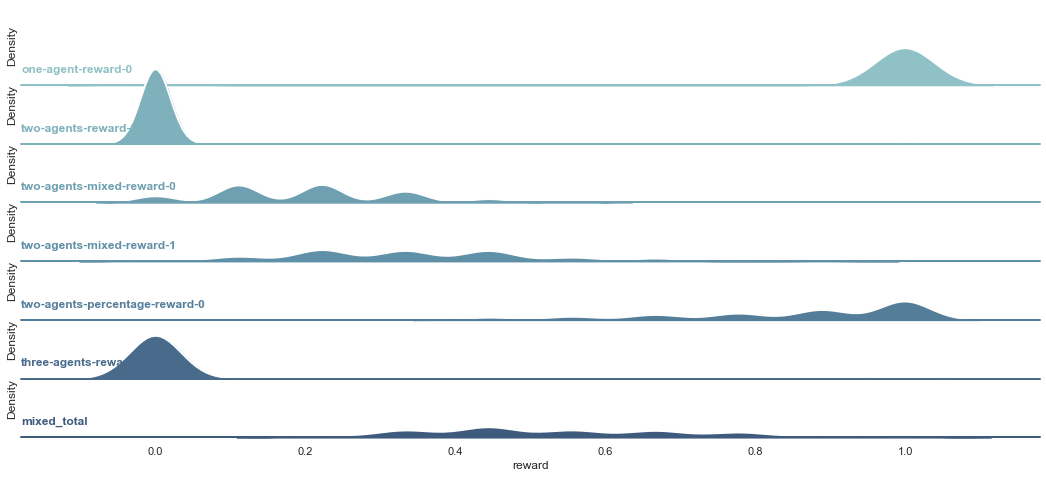

In [19]:
# seaborn plots
x = df_reward["reward"]

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

sns.lineplot(data=df[reward_cols].transpose(), ax=ax)

# sns.catplot(data=df[reward_cols], orient="h", kind="box", ax=ax)

# print(data)

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df_reward, row="setting", hue="setting", aspect=15, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "reward", 
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "reward", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(df_reward, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "reward")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

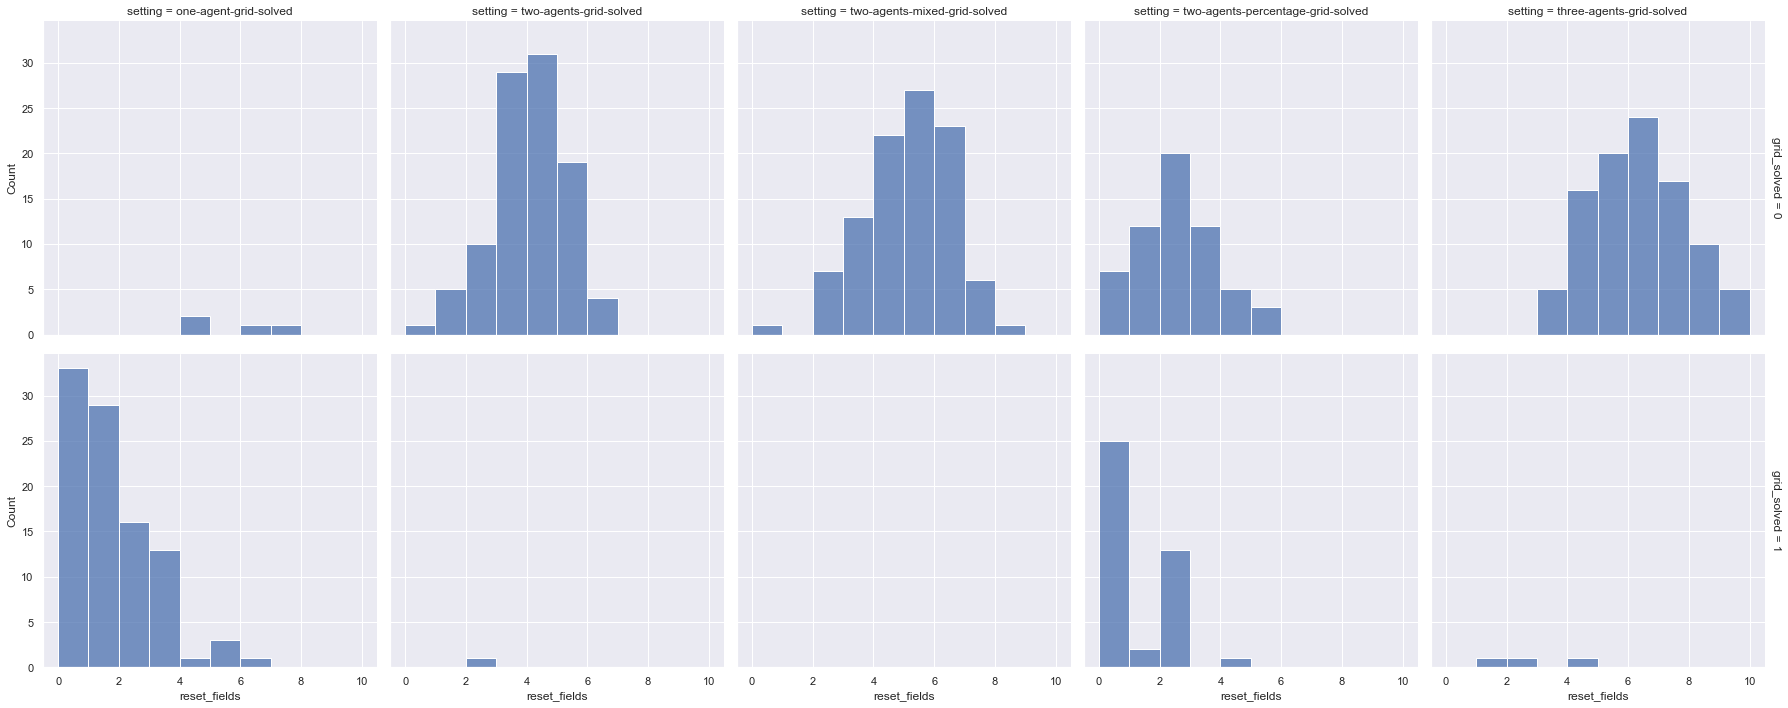

In [15]:
sns.set_theme(style="darkgrid")
sns.displot(
    df_combined_reset_and_solved, x="reset_fields", col="setting", row="grid_solved",
    binwidth=1, height=5, facet_kws=dict(margin_titles=True),
)